In [6]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from copy import deepcopy

### Read test masks

In [7]:
def read_stored_data(stored_folder):
    audio_inputs, text_inputs, visual_inputs, preds, targets = [], [], [], [], []
    audio_masks, text_masks, visual_masks = [], [], []
    for i in range(1, 23):
        visual_masks.append(torch.load(f"{stored_folder}/masks/mask_visual_batch_{i}.pt").cpu().numpy())
        audio_masks.append(torch.load(f"{stored_folder}/masks/mask_audio_batch_{i}.pt").cpu().numpy())
        text_masks.append(torch.load(f"{stored_folder}/masks/mask_text_batch_{i}.pt").cpu().numpy())
        visual_inputs.append(torch.load(f"{stored_folder}/inputs/visual/batch_{i}.pt").cpu().numpy())
        audio_inputs.append(torch.load(f"{stored_folder}/inputs/audio/batch_{i}.pt").cpu().numpy())
        text_inputs.append(torch.load(f"{stored_folder}/inputs/text/batch_{i}.pt").cpu().numpy())
        preds.append(torch.load(f"{stored_folder}/preds/batch_{i}.pt").cpu().numpy())
        targets.append(torch.load(f"{stored_folder}/labels/batch_{i}.pt").cpu().numpy())

    return audio_masks, text_masks, visual_masks, audio_inputs, text_inputs, visual_inputs, preds, targets

def get_unique_ordered_samples(batches):
    unique_samples = []
    for batch in batches:
        for sample in batch:
            unique_samples.append(sample)
    return unique_samples

def group_masks(au_masks: list, txt_masks: list, vis_masks: list, au_inputs: list, txt_inputs: list, vis_inputs: list, group_keys: np.array):
    grouped_dict = {"masks": {}, "inputs": {}}
    keys = list(np.unique(group_keys))
    txt_mask_dict = {int(key): [] for key in keys}
    vis_mask_dict = {int(key): [] for key in keys}
    au_mask_dict = {int(key): [] for key in keys}
    txt_input_dict = {int(key): [] for key in keys}
    vis_input_dict = {int(key): [] for key in keys}
    au_input_dict = {int(key): [] for key in keys}
    for i in range(group_keys.shape[0]):
        au_mask_dict[int(group_keys[i])].append(au_masks[i])
        vis_mask_dict[int(group_keys[i])].append(vis_masks[i])
        txt_mask_dict[int(group_keys[i])].append(txt_masks[i])

        au_input_dict[int(group_keys[i])].append(au_inputs[i])
        vis_input_dict[int(group_keys[i])].append(vis_inputs[i])
        txt_input_dict[int(group_keys[i])].append(txt_inputs[i])
        

    grouped_dict["masks"]["text"] = txt_mask_dict
    grouped_dict["masks"]["visual"] = vis_mask_dict
    grouped_dict["masks"]["audio"] = au_mask_dict

    grouped_dict["inputs"]["text"] = txt_input_dict
    grouped_dict["inputs"]["visual"] = vis_input_dict
    grouped_dict["inputs"]["audio"] = au_input_dict
    
    return grouped_dict

def collapse_over_time(class_to_mask_dict: dict[int: list]):
    collpsed_dict = {cls: [] for cls in class_to_mask_dict.keys()}
    for cls, masks in class_to_mask_dict.items():
        for mask in masks:
            collpsed_dict[cls].append(np.mean(mask, axis=0))
    return collpsed_dict

def gini(x):
    # x: 1D array
    x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def plot_collapsed_per_class(all_target_to_mask_dict, save_path):
    classes = list(all_target_to_mask_dict["text"].keys())
    num_classes = len(classes)
    fig, axes = plt.subplots(num_classes, 3, figsize=(18, 4 * num_classes), 
                             constrained_layout=True)

    modalities = ['Visual', 'Text', 'Audio']
    im = None

    for row_idx, cls in enumerate(classes):
        vis_masks = np.vstack(all_target_to_mask_dict["visual"][cls])
        txt_masks = np.vstack(all_target_to_mask_dict["text"][cls])
        audio_masks = np.vstack(all_target_to_mask_dict["audio"][cls])

        print(f"================ Class {cls} ================")
        print(f"Mean Audio Activation: {np.mean(audio_masks): .4f}, Mean Text Activation: {np.mean(txt_masks): .4f}, Mean Visual Activation: {np.mean(vis_masks): .4f}")
        vis_gini = np.mean(np.array([gini(row) for row in vis_masks]))
        txt_gini = np.mean(np.array([gini(row) for row in txt_masks]))
        audio_gini = np.mean(np.array([gini(row) for row in audio_masks]))
        print(f"Audio Mask Gini: {np.mean(audio_gini): .4f}, Text Mask Gini: {np.mean(txt_gini): .4f}, Visual Mask Gini: {np.mean(vis_gini): .4f}")

        
        masks = [vis_masks, txt_masks, audio_masks]

        for col_idx, (mask, modality) in enumerate(zip(masks, modalities)):
            ax = axes[row_idx, col_idx] if num_classes > 1 else axes[col_idx]
            im = ax.imshow(mask, aspect='auto', cmap='viridis', vmin=0, vmax=1)
            ax.set_title(f'{modality} (Class {cls})')
            ax.set_xlabel('Features')
            ax.set_ylabel('Samples')

    fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal',
                 location='bottom', fraction=0.05, pad=0.005,
                 label='Feedback Mask Activation')
    plt.savefig(f"{save_path}/all_classes_all_modalities_per_class.png", dpi=300)
    plt.show()
    plt.close()

def plot_collapsed_per_modality(all_target_to_mask_dict, save_path):
    classes = list(all_target_to_mask_dict["text"].keys())
    per_class_stacked_vis_masks = []
    per_class_stacked_audio_masks = []
    per_class_stacked_text_masks = []
    for row_idx, cls in enumerate(classes):
        per_class_stacked_vis_masks.append(np.vstack(all_target_to_mask_dict["visual"][cls]))
        per_class_stacked_text_masks.append(np.vstack(all_target_to_mask_dict["text"][cls]))
        per_class_stacked_audio_masks.append(np.vstack(all_target_to_mask_dict["audio"][cls]))

    audio_masks_stacked = np.vstack(per_class_stacked_audio_masks)
    text_masks_stacked = np.vstack(per_class_stacked_text_masks)
    visual_masks_stacked = np.vstack(per_class_stacked_vis_masks)

    masks = [visual_masks_stacked, text_masks_stacked, audio_masks_stacked]
    modalities = ['Visual', 'Text', 'Audio']

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
    im = None

    for ax, mask, modality in zip(axes, masks, modalities):
        im = ax.imshow(mask, aspect='auto', cmap='viridis', vmin=0, vmax=1)
        ax.set_title(modality)
        ax.set_xlabel('Features')
        ax.set_ylabel('Samples')

    fig.colorbar(im, ax=axes, orientation='horizontal', location='bottom',
                 fraction=0.05, pad=0.07, label='Feedback Mask Activation')

    plt.savefig(f"{save_path}/all_modalities.png", dpi=300)
    plt.show()
    plt.close()
    print("================ Per Modality Mean Activation================")
    print(f"Mean Audio Activation: {np.mean(audio_masks_stacked): .4f}, Mean Text Activation: {np.mean(text_masks_stacked): .4f}, Mean Visual Activation: {np.mean(visual_masks_stacked): .4f}")
    vis_gini = np.mean(np.array([gini(row) for row in visual_masks_stacked]))
    txt_gini = np.mean(np.array([gini(row) for row in text_masks_stacked]))
    audio_gini = np.mean(np.array([gini(row) for row in audio_masks_stacked]))
    print(f"Audio Mask Gini: {np.mean(audio_gini): .4f}, Text Mask Gini: {np.mean(txt_gini): .4f}, Visual Mask Gini: {np.mean(vis_gini): .4f}")

def create_saliency_heatmaps_avg_time(target_to_mask, data_folder):
    target_to_mask["masks"]["text"] = collapse_over_time(target_to_mask["masks"]["text"])
    target_to_mask["masks"]["visual"] = collapse_over_time(target_to_mask["masks"]["visual"])
    target_to_mask["masks"]["audio"] = collapse_over_time(target_to_mask["masks"]["audio"])

    plot_collapsed_per_class(target_to_mask["masks"], save_path=f"{data_folder}/figures/saliency_heatmaps")
    plot_collapsed_per_modality(target_to_mask["masks"], save_path=f"{data_folder}/figures/saliency_heatmaps")


Read the masks (audio, text, visual), the predictions and the targets.

Group the mask per modality and per unique pred or target.

In [8]:
DATA_FOLDER = "../ablation_study/base"
os.makedirs(f"{DATA_FOLDER}/figures/saliency_heatmaps", exist_ok=True)

audio_masks, text_masks, visual_masks, audio_inputs, text_inputs, visual_inputs, preds, targets = read_stored_data(stored_folder=DATA_FOLDER)

print(len(audio_masks), len(visual_masks), len(text_masks), len(audio_inputs), len(visual_inputs), len(text_inputs), len(preds), len(targets))

audio_masks = get_unique_ordered_samples(audio_masks)
text_masks = get_unique_ordered_samples(text_masks)
visual_masks = get_unique_ordered_samples(visual_masks)
audio_inputs = get_unique_ordered_samples(audio_inputs)
text_inputs = get_unique_ordered_samples(text_inputs)
visual_inputs = get_unique_ordered_samples(visual_inputs)

preds = [item for arr in preds for item in arr]
targets = [item for arr in targets for item in arr]

test_preds_a7 = np.round(np.clip(np.array(preds), a_min=-3.0, a_max=3.0))
test_truth_a7 = np.round(np.clip(np.array(targets), a_min=-3.0, a_max=3.0))
test_preds_a5 = np.round(np.clip(np.array(preds), a_min=-2.0, a_max=2.0))
test_truth_a5 = np.round(np.clip(np.array(targets), a_min=-2.0, a_max=2.0))

print(len(audio_masks), len(visual_masks), len(text_masks), len(audio_inputs), len(visual_inputs), len(text_inputs), len(test_preds_a7), len(test_truth_a7), len(test_preds_a5), len(test_truth_a5))

22 22 22 22 22 22 22 22
686 686 686 686 686 686 686 686 686 686


In [9]:
# dict["masks"]["modality"]["class"] -> lista apo tis maskes || dict["input"]["modality"]["class"] -> lista apo tis maskes (modality = {text, audio, visual}, class = [-2, 2, 1] i [-3, 3, 1])
a7_target_to_mask = group_masks(au_masks=audio_masks, txt_masks=text_masks, vis_masks=visual_masks, au_inputs=audio_inputs, txt_inputs=text_inputs, vis_inputs=visual_inputs, group_keys=test_truth_a7)

### Saliency Heatmaps over the Feature Dimension.

================ Class -3 ================
Mean Audio Activation:  0.0011, Mean Text Activation:  0.1061, Mean Visual Activation:  0.0082
Audio Mask Gini:  55.5189, Text Mask Gini:  3.3397, Visual Mask Gini:  4.0140
================ Class -2 ================
Mean Audio Activation:  0.0019, Mean Text Activation:  0.1058, Mean Visual Activation:  0.0079
Audio Mask Gini:  3.1630, Text Mask Gini:  3.3544, Visual Mask Gini:  6.4887
================ Class -1 ================
Mean Audio Activation:  0.0019, Mean Text Activation:  0.1059, Mean Visual Activation:  0.0080
Audio Mask Gini:  7.7127, Text Mask Gini:  3.3387, Visual Mask Gini:  5.2978
================ Class 0 ================
Mean Audio Activation:  0.0015, Mean Text Activation:  0.1060, Mean Visual Activation:  0.0088
Audio Mask Gini:  102.4723, Text Mask Gini:  3.3386, Visual Mask Gini:  6.6358
================ Class 1 ================
Mean Audio Activation:  0.0017, Mean Text Activation:  0.1061, Mean Visual Activation:  0.0094
A

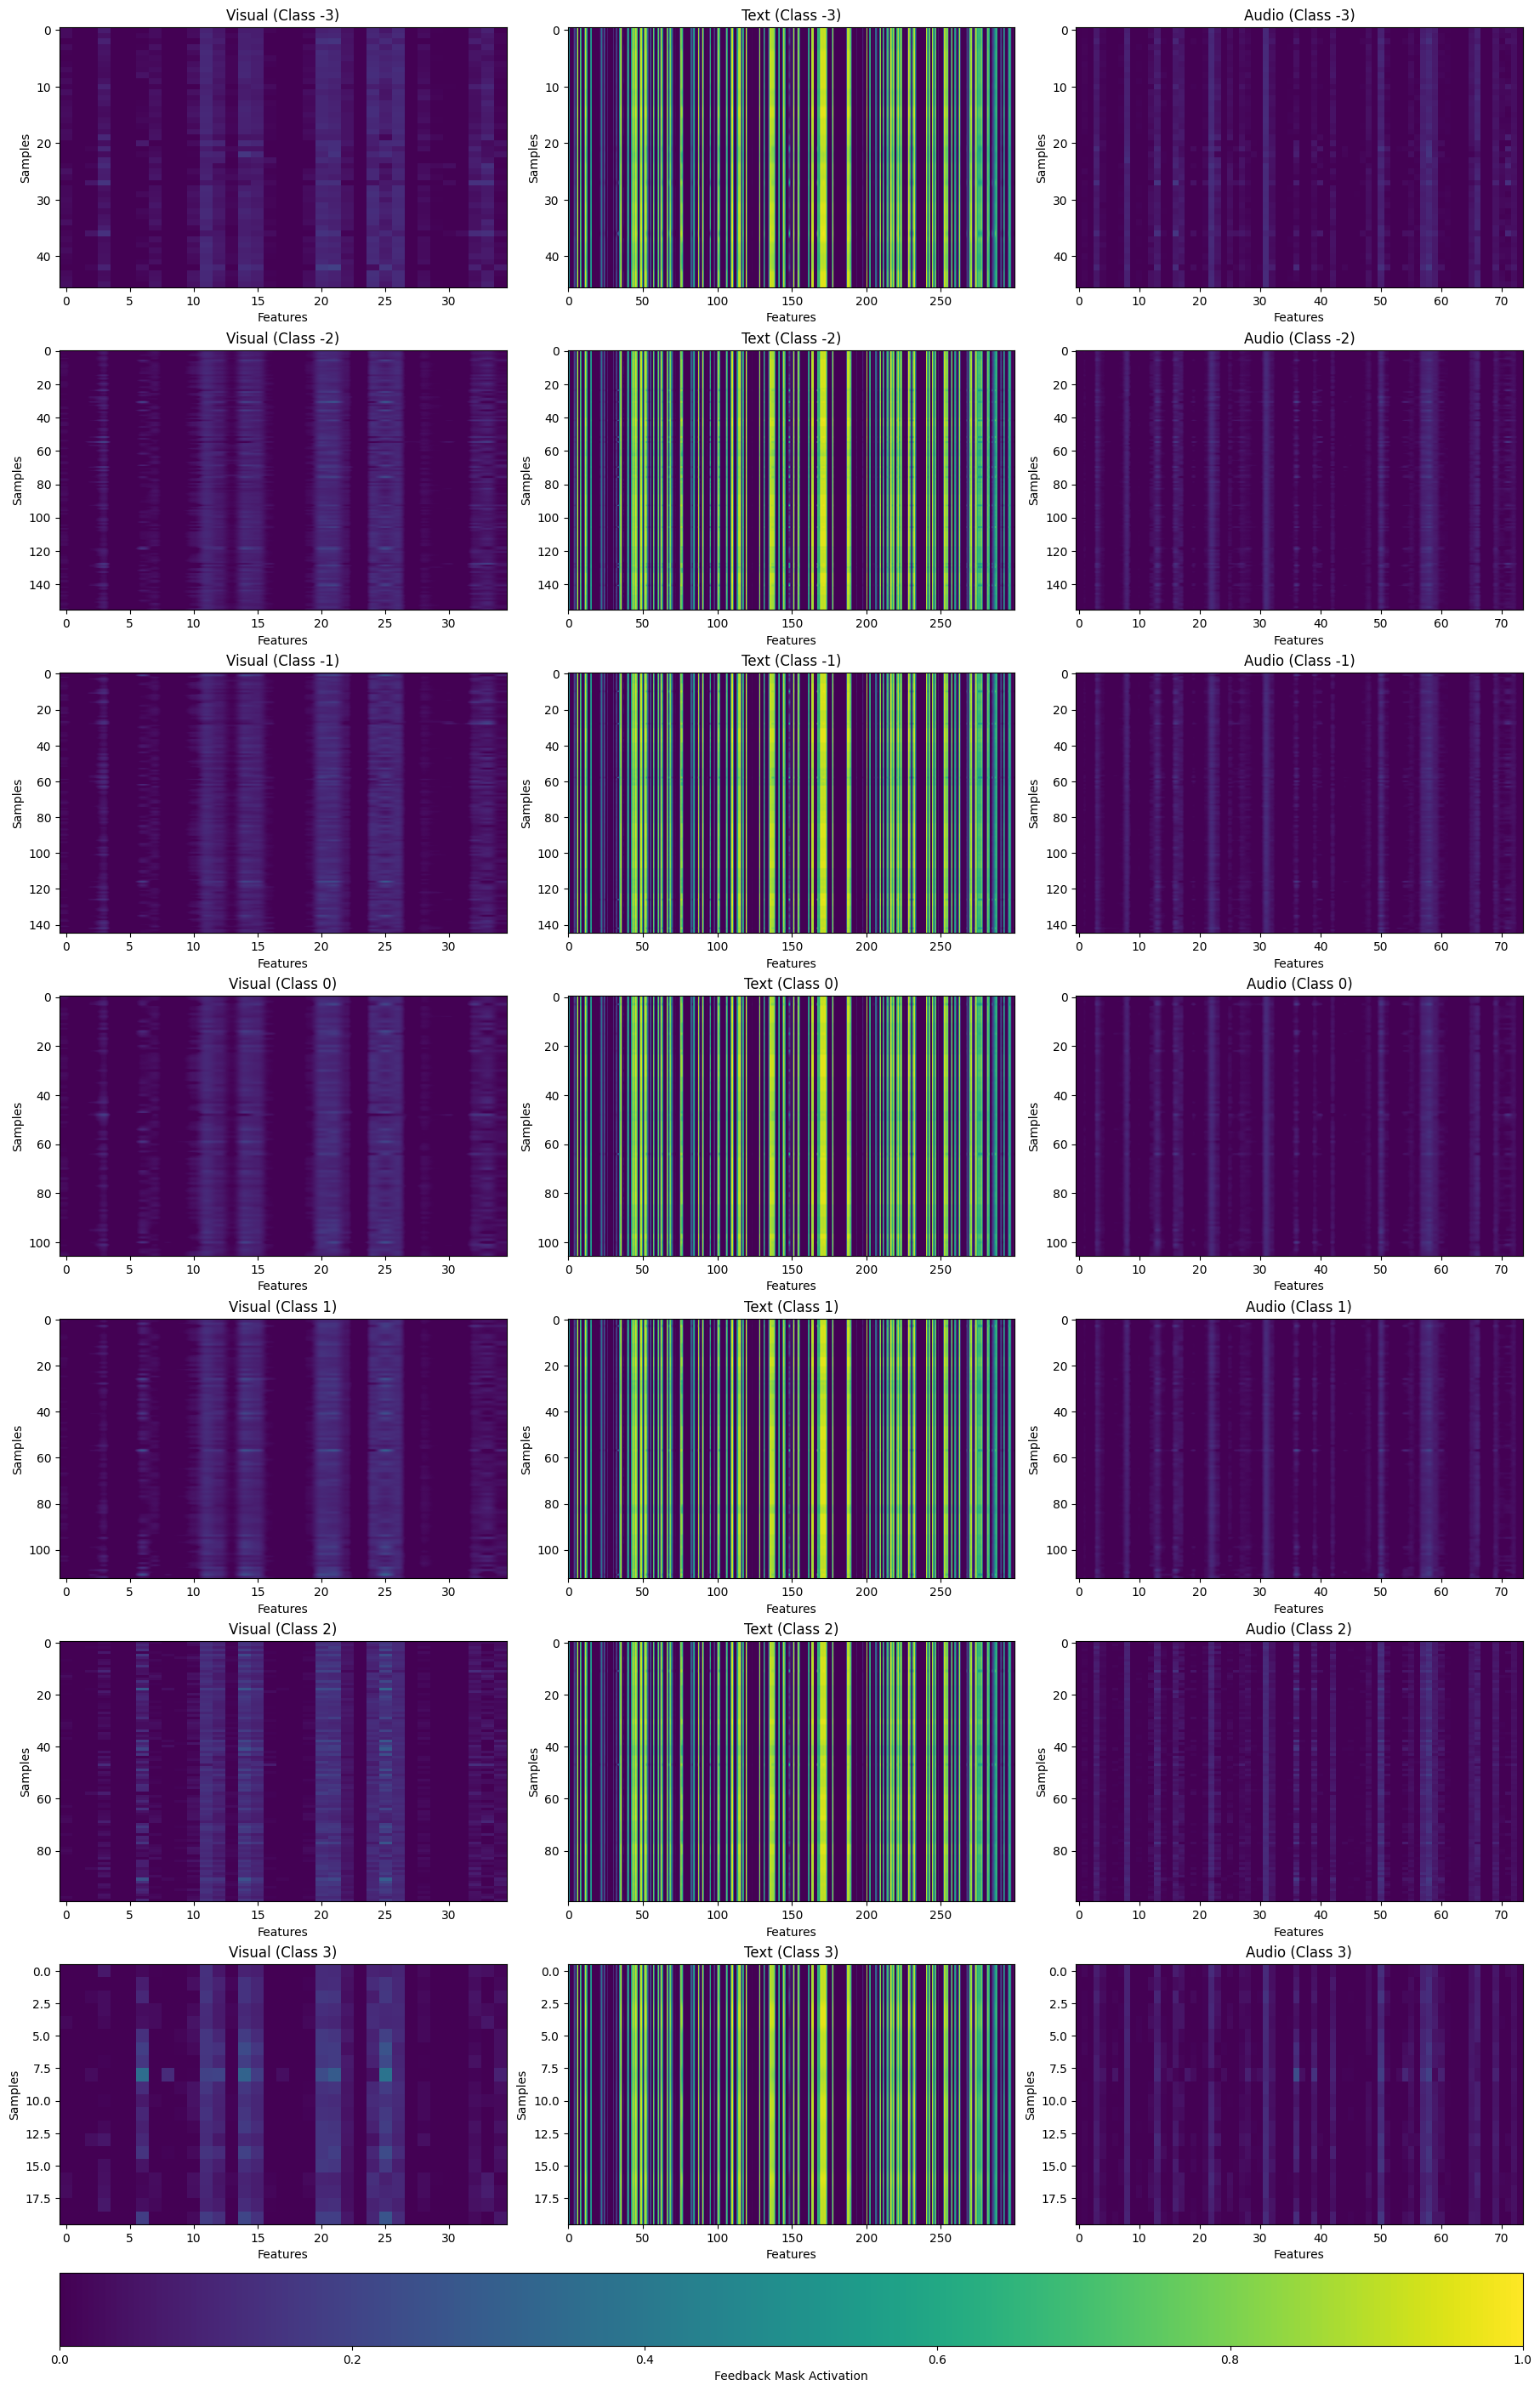

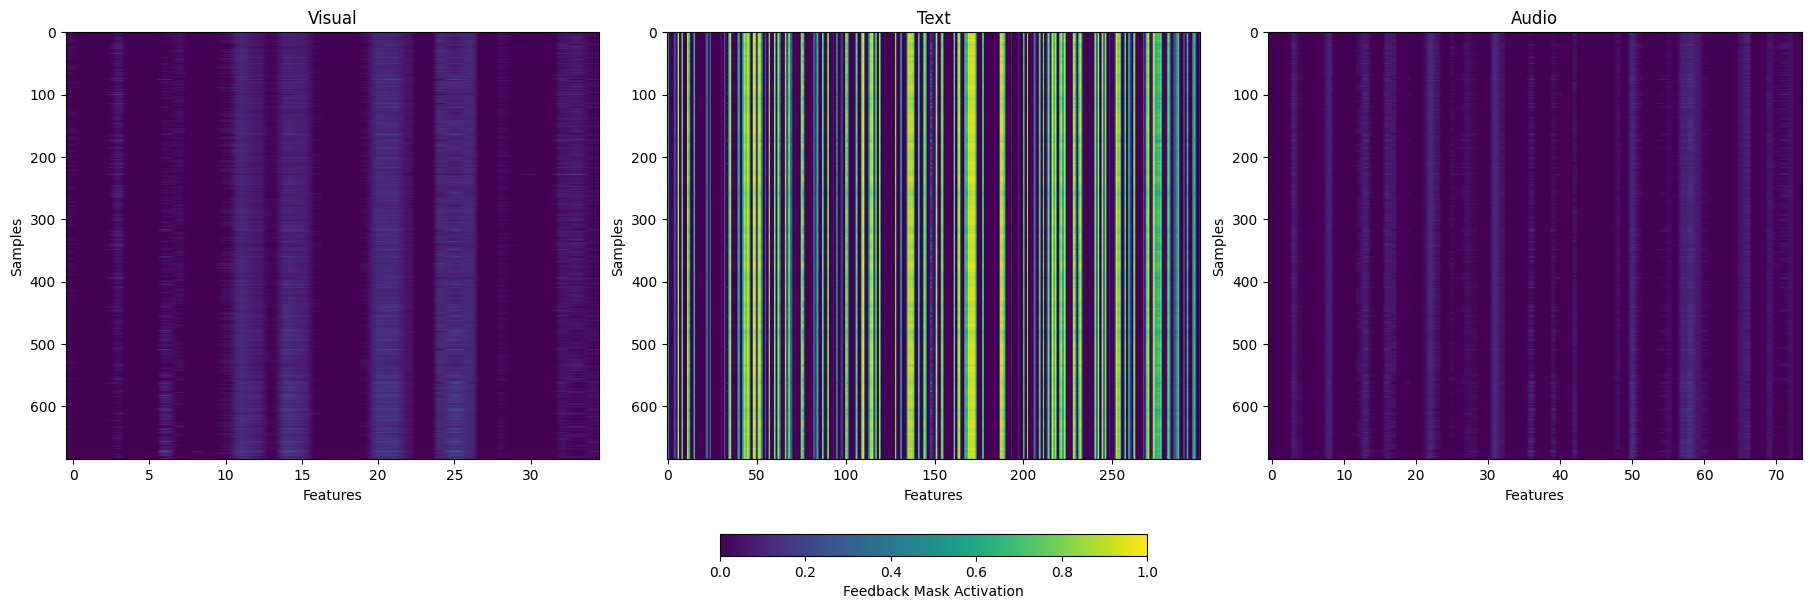

================ Per Modality Mean Activation================
Mean Audio Activation:  0.0018, Mean Text Activation:  0.1060, Mean Visual Activation:  0.0087
Audio Mask Gini:  12.3112, Text Mask Gini:  3.3401, Visual Mask Gini:  5.6957


In [10]:
create_saliency_heatmaps_avg_time(target_to_mask=deepcopy(a7_target_to_mask), data_folder=DATA_FOLDER)

### Cross-Modality Influence Matrix

In [24]:
au_to_txt = torch.load("../ablation_study/base/influence/audio_to_text/batch_1.pt")
vis_to_txt = torch.load("../ablation_study/base/influence/visual_to_text/batch_1.pt")
txt_to_vis = torch.load("../ablation_study/base/influence/text_to_visual/batch_1.pt")
au_to_vis = torch.load("../ablation_study/base/influence/audio_to_visual/batch_1.pt")
txt_to_au = torch.load("../ablation_study/base/influence/text_to_audio/batch_1.pt")
vis_to_au = torch.load("../ablation_study/base/influence/visual_to_audio/batch_1.pt")
inp_au = torch.load("../ablation_study/base/inputs/audio/batch_1.pt")
inp_vis = torch.load("../ablation_study/base/inputs/visual/batch_1.pt")
inp_txt = torch.load("../ablation_study/base/inputs/text/batch_1.pt")
au_to_txt.shape, vis_to_txt.shape, inp_txt.shape, txt_to_vis.shape, au_to_vis.shape, inp_vis.shape, txt_to_au.shape, vis_to_au.shape, inp_au.shape

(torch.Size([32, 42, 300]),
 torch.Size([32, 42, 300]),
 torch.Size([32, 42, 300]),
 torch.Size([32, 42, 35]),
 torch.Size([32, 42, 35]),
 torch.Size([32, 42, 35]),
 torch.Size([32, 42, 74]),
 torch.Size([32, 42, 74]),
 torch.Size([32, 42, 74]))

In [27]:
au_to_txt = torch.load("../ablation_study/base/influence/audio_to_text/batch_20.pt")
vis_to_txt = torch.load("../ablation_study/base/influence/visual_to_text/batch_20.pt")
txt_to_vis = torch.load("../ablation_study/base/influence/text_to_visual/batch_20.pt")
au_to_vis = torch.load("../ablation_study/base/influence/audio_to_visual/batch_20.pt")
txt_to_au = torch.load("../ablation_study/base/influence/text_to_audio/batch_20.pt")
vis_to_au = torch.load("../ablation_study/base/influence/visual_to_audio/batch_20.pt")
inp_au = torch.load("../ablation_study/base/inputs/audio/batch_20.pt")
inp_vis = torch.load("../ablation_study/base/inputs/visual/batch_20.pt")
inp_txt = torch.load("../ablation_study/base/inputs/text/batch_20.pt")
au_to_txt.shape, vis_to_txt.shape, inp_txt.shape, txt_to_vis.shape, au_to_vis.shape, inp_vis.shape, txt_to_au.shape, vis_to_au.shape, inp_au.shape

(torch.Size([32, 51, 300]),
 torch.Size([32, 51, 300]),
 torch.Size([32, 51, 300]),
 torch.Size([32, 51, 35]),
 torch.Size([32, 51, 35]),
 torch.Size([32, 51, 35]),
 torch.Size([32, 51, 74]),
 torch.Size([32, 51, 74]),
 torch.Size([32, 51, 74]))

In [11]:
a7_target_to_mask.keys()

dict_keys(['masks', 'inputs'])

In [12]:
a7_target_to_mask["inputs"].keys(), a7_target_to_mask["masks"].keys()

(dict_keys(['text', 'visual', 'audio']),
 dict_keys(['text', 'visual', 'audio']))

In [13]:
a7_target_to_mask["inputs"]["visual"].keys()

dict_keys([-3, -2, -1, 0, 1, 2, 3])

In [14]:
a7_target_to_mask["inputs"]["visual"][0][0].shape

(42, 35)

In [15]:
a7_target_to_mask["masks"]["text"][0][0].shape, a7_target_to_mask["masks"]["audio"][0][0].shape

((42, 300), (42, 74))

In [16]:
(a7_target_to_mask["inputs"]["visual"][0][0] * a7_target_to_mask["masks"]["visual"][0][0]).mean()

-0.0028267205